# Create spherical harmonic coefficients from an ocean mask
*Author: R. Rietbroek Nov 2024 (r.rietbroek@utwente.nl)*

The ocean function is defined to be one over the ocean and 0 over land areas. This mask function can also be converted to a set of spherical hamronic coefficients. These may for example be used in applying the Sea level equation in the spherical harmonic domain.

## 1. Obtain a (fine ocean grid)
As a starting point we can take a masked grid which was generated using using [an example recipe from geoslurp](https://github.com/strawpants/geoslurp/blob/master/docs/source/notebooks/OceanFunction.ipynb). 

In [1]:
import requests
import os
import xarray as xr
import shxarray
import matplotlib.pyplot as mpl

In [2]:
url="https://github.com/strawpants/geoshapes/raw/refs/heads/master/raster/ocean/ne_10m_oceangrid_0.125.nc"
#temporary storage
outfile="/tmp/"+os.path.basename(url)
if not os.path.exists(outfile):
    r = requests.get(url)
    print(f"Downloading ocean grid {outfile}")
    with open(outfile,'wb') as fid:
        fid.write(r.content)
else:
    print(f"{outfile}, already downloaded")


dsoce=xr.open_dataset(outfile).fillna(0.0)
display(dsoce)

<xarray.Dataset> Size: 33MB
Dimensions:      (latitude: 1440, longitude: 2880)
Coordinates:
  * longitude    (longitude) float64 23kB -179.9 -179.8 -179.7 ... 179.8 179.9
  * latitude     (latitude) float64 12kB -89.94 -89.81 -89.69 ... 89.81 89.94
    spatial_ref  int64 8B ...
Data variables:
    oceanfunc    (latitude, longitude) float64 33MB 0.0 0.0 0.0 ... 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.9
    title:        Gridded Ocean mask generated from natural earth 10m dataset
    institution:  Roelof Rietbroek <r.rietbroek@utwente.nl>, Faculty of Geoin...
    source:       geoslurp
    history:      2024-11-26 14:53:20.439413 geoslurp
    references:   https://geoslurp.wobbly.earth/en/latest/notebooks/OceanFunc...
    comment:      Auto generated

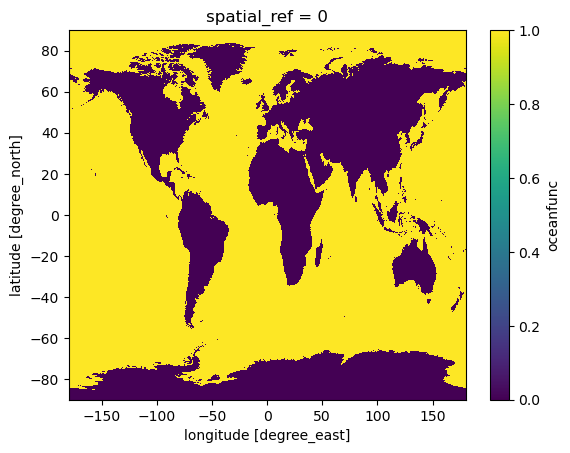

In [3]:
dsoce.oceanfunc.plot()

## 2. Convert the ocean grid to spherical harmonic coefficients

In [4]:
nmax=300 # note: a large nmax can take quite a while
# default uses a naive integration approach
dsocesh=dsoce.oceanfunc.sh.analysis(nmax)
display(dsocesh)
print(f"C00 coefficient (~71% of Earth surface is ocean) {dsocesh.sel(n=0).data[0]}")

<xarray.DataArray (nm: 90601)> Size: 725kB
array([ 7.11538971e-01, -6.02066955e-02, -1.22835400e-01, ...,
        3.12961008e-05, -2.97188334e-05, -2.17756304e-04])
Coordinates:
  * nm       (nm) object 725kB MultiIndex
  * n        (nm) int64 725kB 0 1 1 1 2 2 2 2 ... 300 300 300 300 300 300 300
  * m        (nm) int64 725kB 0 -1 0 1 -2 -1 0 1 ... 294 295 296 297 298 299 300

C00 coefficient (72% of Earth surface is ocean) 0.7115389707690188


## 3. Convert the resulting spherical harmonic coefficients back to a grid and visualize the result

In [5]:
dsoce_back=dsocesh.sh.synthesis(lon=dsoce.longitude,lat=dsoce.latitude)

Text(0.5, 1.0, 'Ocean function after grid -> sh -> grid, nmax=300, (min,max)=(-0.42,1.30)')

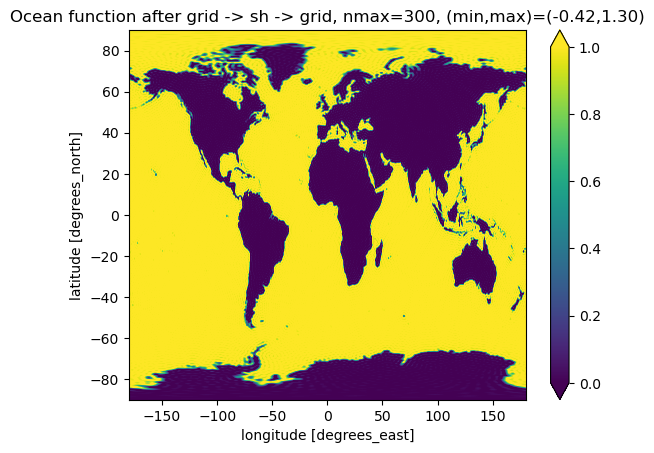

In [6]:
dsoce_back.plot(vmin=0,vmax=1)
ca=mpl.gca()
ca.set_title(f"Ocean function after grid -> sh -> grid, nmax={nmax}, (min,max)=({dsoce_back.min().data.item():.2f},{dsoce_back.max().data.item():.2f})")

Note that differences up to 0.3 are visible due to Gibb's phenomena

## 4. Write the results together with the input grid to the original netcdf file

In [7]:
outfilesh=f"/tmp/ne_10m_oceansh_n{nmax}.nc"
dsocesh.name="oceansh"
dsocesh.reset_index("nm").to_netcdf(outfilesh)